# Preprocesado y Feature Engineering

## Carga de librerías necesarias

In [ ]:
# Importaciones

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from scipy.stats import chi2
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.filterwarnings('ignore')

# Configuración para gráficos
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

## Ingesta de los datos desde el repositorio

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/catalinatrevisan/tp-final-analitica/refs/heads/main/data/raw/online_gaming_behavior_dataset.csv")

## PreProcesamiento Inicial

Se corrige el tipo de dato de "InGamePurchases" para representarlo correctamente como variable booleana.


In [ ]:
# Corrección tipo de dato
df['InGamePurchases'] = df['InGamePurchases'].astype(bool)

In [ ]:
# Eliminar duplicados
duplicados = df.duplicated().sum()

if duplicados > 0:
    df = df.drop_duplicates()
    print("Duplicados eliminados.")
else:
    print("No se detectaron duplicados.")

No se detectaron duplicados.


In [ ]:
# Función auxiliar: clasificacion de los faltantes - test de little (MCAR)

def littles_mcar_test(df):
    """
    Test de Little para evaluar si los datos faltan completamente al azar (MCAR).
    """
    # 1. Crear máscara de faltantes
    missing_mask = df.isnull()

    # 2. Imputar temporalmente con la media
    imputer = SimpleImputer(strategy="mean")
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # 3. Calcular estadístico Chi-cuadrado
    patterns = missing_mask.drop_duplicates()
    chi_square = 0
    dof = 0
    for idx, pattern in patterns.iterrows():
        subset = df.loc[(missing_mask == pattern).all(axis=1)]
        if len(subset) == 0:
            continue
        means = df_imputed.loc[(missing_mask == pattern).all(axis=1)].mean()
        diffs = subset.fillna(0) - means
        chi_square += (diffs**2).sum().sum()
        dof += subset.shape[0] * subset.shape[1]

    p_value = 1 - chi2.cdf(chi_square, dof)
    return chi_square, dof, p_value

In [ ]:
# Imputacion de valores nulos

# Aplicar test solo si hay faltantes en variables numéricas
df_num = df.select_dtypes(include=["number"])
if df_num.isnull().sum().sum() > 0:
    chi2_stat, dof, p = littles_mcar_test(df_num)
    print("\n--- Test de Little ---")
    print(f"Chi2: {chi2_stat:.2f}")
    print(f"Grados de libertad: {dof}")
    print(f"p-valor: {p:.4f}")

    if p > 0.05:
        print("No se rechaza H0: los datos faltan completamente al azar (MCAR).")
        faltantes_tipo = "MCAR"
    else:
        print("Se rechaza H0: los datos NO son MCAR (pueden ser MAR o MNAR).")
        faltantes_tipo = "No MCAR"
else:
    print("No hay valores faltantes en las variables numéricas, se omite el test de Little.")
    faltantes_tipo = None


# Imputacion segun corresponda
df_imputed = df.copy()

# Imputar categóricas con la moda
cat_cols = df_imputed.select_dtypes(exclude=['number']).columns.tolist()
if cat_cols:
    imp_cat = SimpleImputer(strategy='most_frequent')
    df_imputed[cat_cols] = imp_cat.fit_transform(df_imputed[cat_cols])
    print(f"Imputadas {len(cat_cols)} variables categóricas con la moda.")

# Imputar numéricas
num_cols = df_imputed.select_dtypes(include=['number']).columns.tolist()

if num_cols:
    if faltantes_tipo == "MCAR":
        # Imputación simple → MCAR
        imp_num = SimpleImputer(strategy='mean')
        df_imputed[num_cols] = imp_num.fit_transform(df_imputed[num_cols])
        print(f"Imputadas {len(num_cols)} variables numéricas con la media (MCAR).")
    elif faltantes_tipo == "No MCAR":
        # Imputación iterativa → MAR / MNAR
        it_imp = IterativeImputer(
            estimator=ExtraTreesRegressor(n_estimators=300, random_state=0, n_jobs=-1),
            max_iter=10,
            initial_strategy='median',
            skip_complete=True,
            random_state=0
        )
        df_imputed[num_cols] = it_imp.fit_transform(df_imputed[num_cols])
        print(f"Imputadas {len(num_cols)} variables numéricas con método iterativo (MICE).")
    else:
        print("No se detectaron faltantes numéricos, no se aplica imputación.")

# Verificación final
print("\nValores faltantes después de la imputación:")
print(df_imputed.isna().sum().sort_values(ascending=False).head(10))
print("\nImputación completada con éxito.")


No hay valores faltantes en las variables numéricas, se omite el test de Little.
Imputadas 6 variables categóricas con la moda.
No se detectaron faltantes numéricos, no se aplica imputación.

Valores faltantes después de la imputación:
PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
dtype: int64

Imputación completada con éxito.


In [ ]:
# Funcion auxiliar: tratamiento de outliers
def tratar_outliers(df, metodo="winsorize", factor=1.5):
    """
    Trata outliers usando winsorización o recorte según el método elegido.
    - 'winsorize': reemplaza valores extremos por los límites del IQR
    - 'remove': elimina las filas con outliers
    """
    df_out = df.copy()
    for col in df.select_dtypes(include=np.number).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - factor * IQR
        high = Q3 + factor * IQR

        if metodo == "winsorize":
            df_out[col] = np.where(df[col] < low, low,
                            np.where(df[col] > high, high, df[col]))
        elif metodo == "remove":
            df_out = df_out[(df_out[col] >= low) & (df_out[col] <= high)]
    return df_out

In [ ]:
# Tratamiento de outliers (no modificará nada si no hay outliers)
df = tratar_outliers(df, metodo="winsorize")

El dataset queda sin duplicados, nulos u outliers.

## Feature Engineering

In [ ]:
# Eliminamos la variable player_id porque es redundante
df.drop('PlayerID', axis=1, inplace=True)

In [ ]:
# Creación de nuevas variables
required = ['PlayTimeHours', 'SessionsPerWeek', 'InGamePurchases']

# Verificar que las columnas existan
missing = [col for col in required if col not in df.columns]

if missing:
    print("Faltan columnas:", missing)
else:
    df['AvgHoursPerSession'] = df['PlayTimeHours'] / df['SessionsPerWeek']
    df['HighSpender'] = df['InGamePurchases'].astype(bool)


Se crean variables derivadas de interés:

- AvgHoursPerSession: mide el promedio de horas por sesión, para identificar jugadores intensivos.
- HighSpender: transforma la compra in-game en variable binaria para futuros análisis de segmentación.

In [ ]:
# Revisión final del dataset
print(f"Dimensiones finales del dataset: {df.shape}")

# Primeras filas para obtener una vista general
print("\nPrimeras filas:")
display(df.head())

# Informacion general sobre tipos de datos y nulos
print("\nInformación del dataset:")
print(df.info())

Dimensiones finales del dataset: (40034, 14)

Primeras filas:


,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,AvgHoursPerSession,HighSpender
0,43.0,Male,Other,Strategy,16.271119,False,Medium,6.0,108.0,79.0,25.0,Medium,2.711853,False
1,29.0,Female,USA,Strategy,5.525961,False,Medium,5.0,144.0,11.0,10.0,Medium,1.105192,False
2,22.0,Female,USA,Sports,8.223755,False,Easy,16.0,142.0,35.0,41.0,High,0.513985,False
3,35.0,Male,USA,Action,5.265351,True,Easy,9.0,85.0,57.0,47.0,Medium,0.585039,True
4,33.0,Male,Europe,Action,15.531945,False,Medium,2.0,131.0,95.0,37.0,Medium,7.765972,False



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        40034 non-null  float64
 1   Gender                     40034 non-null  object 
 2   Location                   40034 non-null  object 
 3   GameGenre                  40034 non-null  object 
 4   PlayTimeHours              40034 non-null  float64
 5   InGamePurchases            40034 non-null  bool   
 6   GameDifficulty             40034 non-null  object 
 7   SessionsPerWeek            40034 non-null  float64
 8   AvgSessionDurationMinutes  40034 non-null  float64
 9   PlayerLevel                40034 non-null  float64
 10  AchievementsUnlocked       40034 non-null  float64
 11  EngagementLevel            40034 non-null  object 
 12  AvgHoursPerSession         40034 non-null  float64
 13  HighSpender         

In [ ]:
# Identificamos los diferentes tipos de columnas
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

In [ ]:
categorical_cols = categorical_cols.append(pd.Index(["HighSpender"]))
numeric_cols = numeric_cols.append(pd.Index(["AvgHoursPerSession"]))

print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {numeric_cols}")

Variables categóricas: Index(['Gender', 'Location', 'GameGenre', 'InGamePurchases', 'GameDifficulty',
       'EngagementLevel', 'HighSpender', 'HighSpender'],
      dtype='object')
Variables numéricas: Index(['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes',
       'PlayerLevel', 'AchievementsUnlocked', 'AvgHoursPerSession',
       'AvgHoursPerSession'],
      dtype='object')


El dataset queda limpio, sin nulos ni duplicados, con variables relevantes y derivadas.

## Preprocesamiento para machine learning

In [ ]:
# Verificamos los valores únicos de las columnas categóricas
for col in categorical_cols:
    print(f"{col} = {df[col].unique()}")

Gender = ['Male' 'Female']
Location = ['Other' 'USA' 'Europe' 'Asia']
GameGenre = ['Strategy' 'Sports' 'Action' 'RPG' 'Simulation']
InGamePurchases = [False  True]
GameDifficulty = ['Medium' 'Easy' 'Hard']
EngagementLevel = ['Medium' 'High' 'Low']
HighSpender = [False  True]
HighSpender = [False  True]


In [ ]:
# Encoding de variables categóricas

# OneHot Encoding para nominales
one_hot_cols = ["Gender", "Location", "GameGenre", "HighSpender", "InGamePurchases"]
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Ordinal Encoding para ordenadas
# GameDifficulty: Easy < Medium < Hard
difficulty_map = {"Easy": 0, "Medium": 1, "Hard": 2}
df["GameDifficulty_enc"] = df["GameDifficulty"].map(difficulty_map)

# EngagementLevel: Low < Medium < High
engagement_map = {"Low": 0, "Medium": 1, "High": 2}
df["EngagementLevel_enc"] = df["EngagementLevel"].map(engagement_map)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        40034 non-null  float64
 1   PlayTimeHours              40034 non-null  float64
 2   GameDifficulty             40034 non-null  object 
 3   SessionsPerWeek            40034 non-null  float64
 4   AvgSessionDurationMinutes  40034 non-null  float64
 5   PlayerLevel                40034 non-null  float64
 6   AchievementsUnlocked       40034 non-null  float64
 7   EngagementLevel            40034 non-null  object 
 8   AvgHoursPerSession         40034 non-null  float64
 9   Gender_Male                40034 non-null  bool   
 10  Location_Europe            40034 non-null  bool   
 11  Location_Other             40034 non-null  bool   
 12  Location_USA               40034 non-null  bool   
 13  GameGenre_RPG              40034 non-null  boo

In [ ]:
# Escalamiento/normalización de variables numéricas

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Escaladores
sc_age_level = StandardScaler()
sc_minmax = MinMaxScaler()
sc_robust = RobustScaler()

# Aplicar escaladores según lo recomendado
df["Age"] = sc_age_level.fit_transform(df[["Age"]])
df["PlayerLevel"] = sc_age_level.fit_transform(df[["PlayerLevel"]])

df["SessionsPerWeek"] = sc_minmax.fit_transform(df[["SessionsPerWeek"]])
df["AchievementsUnlocked"] = sc_minmax.fit_transform(df[["AchievementsUnlocked"]])

df["PlayTimeHours"] = sc_robust.fit_transform(df[["PlayTimeHours"]])
df["AvgSessionDurationMinutes"] = sc_robust.fit_transform(df[["AvgSessionDurationMinutes"]])

In [ ]:
# Revisión de multicolinealidad

import pandas as pd
import numpy as np

# Variables numéricas + ordinales
vif_cols = [
    "Age",
    "PlayTimeHours",
    "SessionsPerWeek",
    "AvgSessionDurationMinutes",
    "PlayerLevel",
    "AchievementsUnlocked",
    "GameDifficulty_enc",
    "EngagementLevel_enc"
]


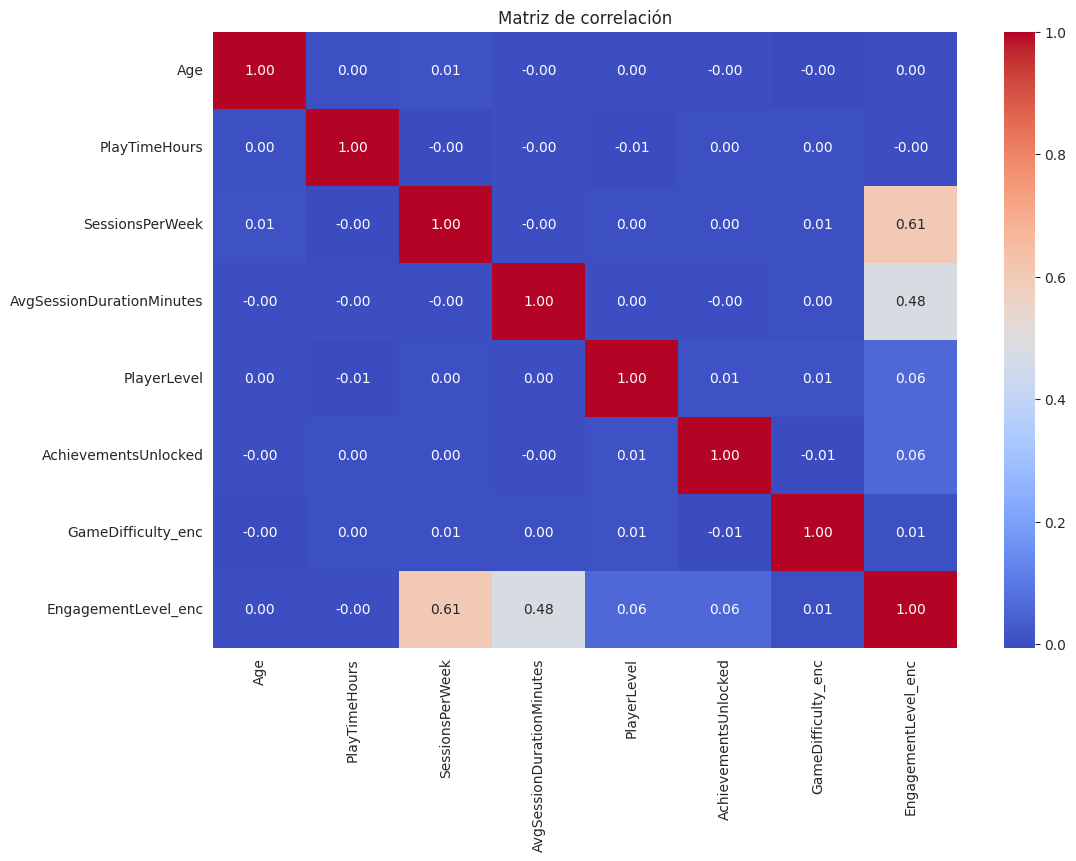

In [ ]:
# Matriz de correlación

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df[vif_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[vif_cols].copy()

vif_data = pd.DataFrame()
vif_data["feature"] = vif_cols
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data


,feature,VIF
0,Age,1.000122
1,PlayTimeHours,1.000078
2,SessionsPerWeek,6.431664
3,AvgSessionDurationMinutes,1.554630
4,PlayerLevel,1.007548
5,AchievementsUnlocked,2.520731
6,GameDifficulty_enc,1.612257
7,EngagementLevel_enc,7.161574


In [ ]:
df["PlayIntensity"] = df["SessionsPerWeek"] * df["AvgSessionDurationMinutes"]

In [ ]:
numeric_cols = numeric_cols.append(pd.Index(["PlayIntensity"]))

**Revisión de multicolinealidad:**

Se evaluaron las correlaciones entre variables numéricas y el VIF (Variance Inflation Factor).

Los resultados mostraron que la mayoría de las variables presentan baja colinealidad.

Solo SessionsPerWeek y EngagementLevel_enc arrojaron VIF moderados (entre 6 y 7), lo cual indica cierta relación, pero no alcanza niveles considerados problemáticos (VIF > 10).

Dado que sesiones por semana y duración promedio suelen describir conductas complementarias del jugador, se creó una nueva variable combinada: PlayIntensity = SessionsPerWeek * AvgSessionDurationMinutes.

Esta variable resume la conducta de juego sin sustituir completamente a las originales. Tras verificar nuevamente el VIF, no se justifica eliminar SessionsPerWeek ni AvgSessionDurationMinutes, ya que su multicolinealidad no es lo suficientemente elevada como para afectar el modelo. Por lo tanto, se conserva PlayIntensity junto con las variables originales.

In [ ]:
df.to_csv('online_gaming_behavior_preprocessed.csv', index=False)
print("Dataset guardado como 'online_gaming_behavior_preprocesado.csv'")

Dataset guardado como 'online_gaming_behavior_preprocesado.csv'
